In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torchvision import datasets, transforms
import torchvision            # <-- añade esta línea
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import trange


In [25]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
11.8


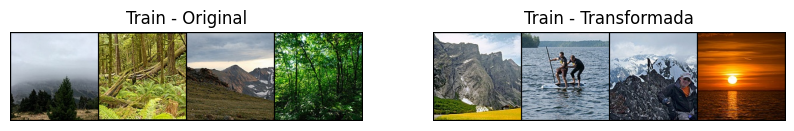

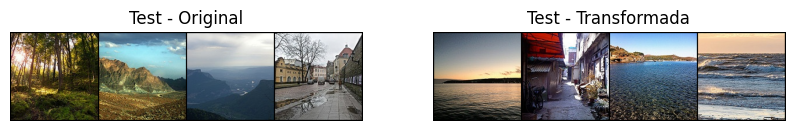

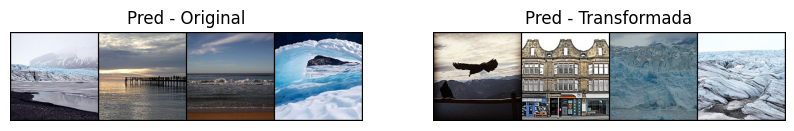

In [26]:
# Definir transformaciones
transform_original = transforms.ToTensor()
transform_transformada = transforms.Compose([
    transforms.RandomHorizontalFlip(),  #voltea aleatoriamente
    transforms.ToTensor()
])

batch_size = 4
data_dirs = {
    'Train': 'seg_train/seg_train',
    'Test': 'seg_test/seg_test',
    'Pred': 'seg_pred/seg_pred'
}

# Cargar datasets y dataloaders
datasets_dict = {}
dataloaders = {}
for name, path in data_dirs.items():
    datasets_dict[f'{name}_orig'] = datasets.ImageFolder(root=path, transform=transform_original)
    datasets_dict[f'{name}_trans'] = datasets.ImageFolder(root=path, transform=transform_transformada)
    dataloaders[f'{name}_orig'] = DataLoader(datasets_dict[f'{name}_orig'], batch_size=batch_size, shuffle=True)
    dataloaders[f'{name}_trans'] = DataLoader(datasets_dict[f'{name}_trans'], batch_size=batch_size, shuffle=True)

def imshow(img_batch, title):
    npimg = img_batch.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    
# Mostrar un lote de cada conjunto
for name in ['Train', 'Test', 'Pred']:
    # Cargar un lote
    imgs_orig, _ = next(iter(dataloaders[f'{name}_orig']))
    imgs_tran, _ = next(iter(dataloaders[f'{name}_trans']))
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    imshow(torchvision.utils.make_grid(imgs_orig), f'{name} - Original')
    plt.subplot(1,2,2)
    imshow(torchvision.utils.make_grid(imgs_tran), f'{name} - Transformada')
    plt.show()

Usando dispositivo: cuda
Dispositivo que se está usando: cuda
Nombre de la GPU: NVIDIA GeForce GTX 1070
Memoria GPU libre/total (MB): (7236222976, 8589672448)


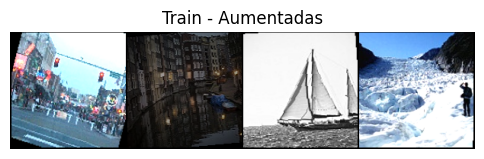

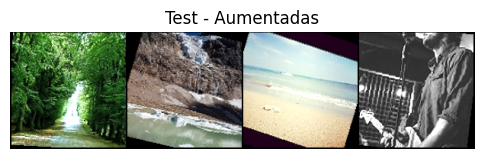

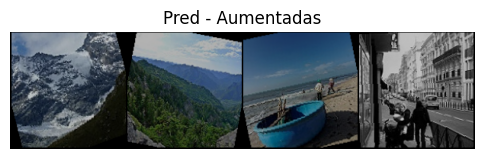

In [27]:
# Configura el dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo que se está usando:", device)

if device.type == "cuda":
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))
    print("Memoria GPU libre/total (MB):", torch.cuda.mem_get_info())
else:
    print("¡No se está usando la GPU!")


# Definir cinco aumentos de datos
transform_augment = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=150, scale=(0.8, 1.0)),  # <--- debe ser exactamente 150
    transforms.ColorJitter(brightness=0.4),
    transforms.RandomGrayscale(p=0.25),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='seg_train', transform=transform_augment)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

batch_size = 4
data_dirs = {
    'Train': 'seg_train',
    'Test': 'seg_test',
    'Pred': 'seg_pred'
}

# Cargar datasets y dataloaders con la transformación de aumento
datasets_aug = {name: datasets.ImageFolder(root=path, transform=transform_augment)
                for name, path in data_dirs.items()}
dataloaders_aug = {name: DataLoader(ds, batch_size=batch_size, shuffle=True)
                   for name, ds in datasets_aug.items()}

def imshow(img_batch, title):
    npimg = img_batch.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Mostrar un lote aumentado de cada conjunto
for name in ['Train', 'Test', 'Pred']:
    imgs_aug, _ = next(iter(dataloaders_aug[name]))
    plt.figure(figsize=(6, 6))
    imshow(torchvision.utils.make_grid(imgs_aug), f'{name} - Aumentadas')
    plt.show()

In [28]:
for images, labels in train_loader:
    print(images.shape)  # Debería dar: torch.Size([4, 3, 150, 150])
    break  # Solo para comprobar


torch.Size([4, 3, 150, 150])


In [ ]:
# Modelo de red convolucional
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 150 → 75
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 75 → 37
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*37*37, 128)  # 64 canales, 37x37 después del segundo pool
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Inicializa modelo, función de pérdida y optimizador
model = SimpleCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Entrenamiento con visualización de progreso
epochs = 30
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    batch_count = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        if batch_idx == 0:
            print("Dispositivo actual de los tensores:", images.device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batch_count += 1

        # Print de avance cada 20 lotes
        if batch_idx % 20 == 0:
            print(f"Época [{epoch+1}/{epochs}] - Lote {batch_idx}/{len(train_loader)} procesado")

    avg_loss = train_loss / batch_count
    print(f"Época [{epoch+1}/{epochs}] - Pérdida: {avg_loss:.4f}")

Dispositivo actual de los tensores: cuda:0
Época [1/5] - Lote 0/3509 procesado
Época [1/5] - Lote 20/3509 procesado
Época [1/5] - Lote 40/3509 procesado
Época [1/5] - Lote 60/3509 procesado
Época [1/5] - Lote 80/3509 procesado
Época [1/5] - Lote 100/3509 procesado
Época [1/5] - Lote 120/3509 procesado
Época [1/5] - Lote 140/3509 procesado
Época [1/5] - Lote 160/3509 procesado
Época [1/5] - Lote 180/3509 procesado
Época [1/5] - Lote 200/3509 procesado
Época [1/5] - Lote 220/3509 procesado
Época [1/5] - Lote 240/3509 procesado
Época [1/5] - Lote 260/3509 procesado
Época [1/5] - Lote 280/3509 procesado
Época [1/5] - Lote 300/3509 procesado
Época [1/5] - Lote 320/3509 procesado
Época [1/5] - Lote 340/3509 procesado
Época [1/5] - Lote 360/3509 procesado
Época [1/5] - Lote 380/3509 procesado
Época [1/5] - Lote 400/3509 procesado
Época [1/5] - Lote 420/3509 procesado
Época [1/5] - Lote 440/3509 procesado
Época [1/5] - Lote 460/3509 procesado
Época [1/5] - Lote 480/3509 procesado
Época [1/5] -

In [32]:
# Define las transformaciones: resize + ToTensor
transform_test = transforms.Compose([
    transforms.Resize((150, 150)),  # <-- fuerza el tamaño de todas las imágenes
    transforms.ToTensor()
])

# Prepara el DataLoader de test sin aumentos (solo resize y tensor)
test_dataset = datasets.ImageFolder(root='seg_test/seg_test', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluación
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

final_acc = correct / total
print(f'Precisión final en el conjunto de test: {final_acc * 100:.2f}%')


Precisión final en el conjunto de test: 14.57%
